In [224]:
import os
import pandas as pd
from datetime import datetime
from openai import OpenAI
from bertopic import BERTopic
import numpy as np

In [221]:
# Folder where your CSV files are stored
data_folder = 'data/'

# Function to extract metadata from the file name
def extract_metadata(filename):
    parts = filename.split('_')
    action_item = int(parts[0])
    section = parts[1]
    date = datetime.strptime(parts[2].replace('.csv', ''), '%m%d%y').strftime('%m/%d/%Y')
    return action_item, section, date

# Process all CSV files in the data folder and merge them into one
def process_all_files(data_folder):
    all_data = []  # List to store all processed data
    short_lines_data = []  # List to store lines with <= 3 words
    total_lines_across_files = 0

    # Iterate through all files in the folder
    for filename in os.listdir(data_folder):
        if filename.endswith('.csv'):
            try:
                # Extract metadata from file name
                action_item, section, date = extract_metadata(filename)

                # Load the CSV file as plain text and treat each line as a chunk
                file_path = os.path.join(data_folder, filename)
                with open(file_path, 'r') as file:
                    lines = file.readlines()
                
                # Count the total number of lines before stripping
                total_lines_before_stripping = len(lines)
                total_lines_across_files += total_lines_before_stripping  # Add to the overall total
                print(f"{filename}: Total lines before stripping: {total_lines_before_stripping}")

                # Clean the lines
                lines = [line.strip() for line in lines if line.strip()]

                # Separate lines based on word count
                long_lines = [line for line in lines if len(line.split()) > 8]
                short_lines = [line for line in lines if len(line.split()) <= 8]

                # Create a DataFrame where each long line is a row
                if long_lines:
                    df = pd.DataFrame(long_lines, columns=['text'])
                    df['action_item'] = action_item
                    df['section'] = section
                    df['date'] = date
                    all_data.append(df)

                # Store short lines in a separate DataFrame
                if short_lines:
                    short_df = pd.DataFrame(short_lines, columns=['text'])
                    short_df['action_item'] = action_item
                    short_df['section'] = section
                    short_df['date'] = date
                    short_lines_data.append(short_df)

            except Exception as e:
                print(f"Error processing {filename}: {e}")

    # Merge all the DataFrames for long lines into one
    merged_df = pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()

    # Merge all the DataFrames for short lines into one
    short_lines_df = pd.concat(short_lines_data, ignore_index=True) if short_lines_data else pd.DataFrame()

    # Print the final total number of lines across all files
    #print(f"\nTotal number of lines across all files: {total_lines_across_files}")

    # Return both DataFrames
    return merged_df, short_lines_df

# Run the function to process all files and return the DataFrames
long_lines_df_8, short_lines_df_8 = process_all_files(data_folder)

0_C2_112123.csv: Total lines before stripping: 27
0_C1_052124.csv: Total lines before stripping: 45
0_C2_041624.csv: Total lines before stripping: 29
1_B4_081523.csv: Total lines before stripping: 14
1_B4_072324.csv: Total lines before stripping: 65
1_B3_013024.csv: Total lines before stripping: 31
0_C2_051623.csv: Total lines before stripping: 26
1_B2_091923.csv: Total lines before stripping: 44
0_C2_031924.csv: Total lines before stripping: 28
1_B1_072324.csv: Total lines before stripping: 32
1_B6_013024.csv: Total lines before stripping: 16
0_C1_062023.csv: Total lines before stripping: 181
0_C1_041823.csv: Total lines before stripping: 35
0_C3_061824.csv: Total lines before stripping: 48
1_C2_072623.csv: Total lines before stripping: 39
0_B3_022024.csv: Total lines before stripping: 74
0_B1_032123.csv: Total lines before stripping: 31
1_B3_041823.csv: Total lines before stripping: 10
1_B1_061824.csv: Total lines before stripping: 7
1_B3_062023.csv: Total lines before stripping: 191

In [225]:

client = OpenAI(
  api_key=
)



# Function to get embeddings from OpenAI
def get_embedding(text):
    response = client.embeddings.create( model="text-embedding-3-large", input=text, encoding_format="float", dimensions= 512)
    return response.data[0].embedding

# Add embeddings to the long_lines_df
def add_embeddings_to_df(df):
    # Apply the get_embedding function to the 'text' column
    df['embedding'] = df['text'].apply(get_embedding)
    return df

# Assuming long_lines_df already exists from previous steps
long_lines_df_8_with_embeddings = add_embeddings_to_df(long_lines_df_8)

# Display the DataFrame with embeddings
print(long_lines_df_8_with_embeddings.head())

# Optionally, save the DataFrame with embeddings to a CSV file
long_lines_df_8_with_embeddings.to_csv('long_lines_with_embeddings.csv', index=False)

                                                text  action_item section  \
0  Informational Briefing by University of Hawai‘...            0      C2   
1  Dr. Yinphan Tsang, University of Hawaiʻi, Asso...            0      C2   
2  Dr. Ayron Strauch introduced Dr. Tsang and her...            0      C2   
3  Thank you for your research. Seems like the ri...            0      C2   
4  That's definitely a very unfortunate situation...            0      C2   

         date                                          embedding  
0  11/21/2023  [0.024119375, -0.040089425, -0.022450078, -0.0...  
1  11/21/2023  [-0.007699211, 0.009600094, -0.017184485, -0.0...  
2  11/21/2023  [-0.013201765, -0.06842258, -0.023743473, -0.0...  
3  11/21/2023  [-0.05819176, -0.0128431935, -0.03045507, -0.0...  
4  11/21/2023  [-0.0008313168, -0.0369649, -0.015780263, -0.0...  


In [226]:
from bertopic.representation import OpenAI
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_model = CountVectorizer(stop_words="english")
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
representation_model = OpenAI(client, delay_in_seconds=10, model="gpt-4o-mini",chat=True)

# Assuming 'text' and 'embedding' columns are in the long_lines_df
texts = long_lines_df_8_with_embeddings['text'].tolist()  # Extract text
embeddings = np.array(long_lines_df_8_with_embeddings['embedding'].tolist())  # Convert embeddings to numpy array

# Create a BERTopic model
topic_model = BERTopic(
    nr_topics="auto",                 # Reduce the number of topics (int or None)
    top_n_words=15,                 # The number of words per topic
    min_topic_size=15,              # Minimum size of a topic cluster
    low_memory=False,               # Reduce memory usage at the cost of slower speed
    embedding_model=None,           # Model used to embed the text (you can use custom embeddings or models like BERT)
    vectorizer_model=vectorizer_model,        
    calculate_probabilities=False,  # Calculate the probability of topics per document
    seed_topic_list=None,           # Seed topics with certain words
    language="english",             # The language of the model
    verbose=False,                   # Set to True to get detailed output
    #ctfidf_model=ctfidf_model,
    representation_model=representation_model
)

# Fit BERTopic on the texts and precomputed embeddings
topics, probabilities = topic_model.fit_transform(texts, embeddings)


In [229]:
# Reduce outliers using the `embeddings` strategy
new_topics = topic_model.reduce_outliers(texts, topics, strategy="embeddings", embeddings=embeddings)

In [257]:
# Add the topic labels to the DataFrame
long_lines_df_8_with_embeddings['topic'] = new_topics

# Display the DataFrame with topics
long_lines_df_8_with_embeddings[['text', 'topic']].head()


,text,topic
0,"Informational Briefing by University of Hawai‘i Biota Survey in Hālawa Stream, O‘ahu",26
1,"Dr. Yinphan Tsang, University of Hawaiʻi, Associate Professor in Hydrology",21
2,Dr. Ayron Strauch introduced Dr. Tsang and her team from the University of Hawaiʻi. She explained the effects of the Navy’s water discharge from the Hālawa Shaft into South Hālawa Stream.,21
3,Thank you for your research. Seems like the rising tide floated all the species or it benefited all the species. Will over time the non-native species propose a habitat transforming risk because they outcompete or they are predators of the natives?,19
4,"That's definitely a very unfortunate situation but that's what we are seeing right now and so far. You are probably already aware that we are experiencing a quite unusual drought situation this year. I think that's also contributing to this unprecedented dry condition that might have increased this environmental stressor like hotter environment and allow those more tolerant invasive species that can stay there while our native is probably not so happy there. So yes, that's likely what's going on right now.",3


In [258]:
# Visualize the topics
topic_model.visualize_topics()

In [180]:
long_lines_df_8_with_embeddings.to_csv('long_lines_with_embeddings.csv', index=False)

In [214]:
topic_model.get_topic(6)[0][0]


'Community Engagement and Public Outreach in Water Resource Management'

In [259]:
# Ensure the 'date' column is in datetime format
long_lines_df_8_with_embeddings['date'] = pd.to_datetime(long_lines_df_8_with_embeddings['date'])

# Group by 'date' and 'topic', then count the number of occurrences of each topic per date
topic_counts_per_date = long_lines_df_8_with_embeddings.groupby(['date', 'topic']).size().reset_index(name='count')

# Display the result
print(topic_counts_per_date)

          date  topic  count
0   2023-01-24      0     46
1   2023-01-24      1      1
2   2023-01-24      2      4
3   2023-01-24      3      7
4   2023-01-24      7     34
5   2023-01-24      8      1
6   2023-01-24      9      1
7   2023-01-24     10      3
8   2023-01-24     13      3
9   2023-01-24     17      2
10  2023-01-24     18      7
11  2023-01-24     19      1
12  2023-01-24     24     12
13  2023-01-24     28      2
14  2023-01-24     29      2
15  2023-03-21      1     36
16  2023-03-21      2      8
17  2023-03-21      3      8
18  2023-03-21      4     11
19  2023-03-21      5      1
20  2023-03-21      7      4
21  2023-03-21      8     14
22  2023-03-21      9      4
23  2023-03-21     10      4
24  2023-03-21     12      5
25  2023-03-21     13      9
26  2023-03-21     14      3
27  2023-03-21     15     19
28  2023-03-21     16      1
29  2023-03-21     18      2
30  2023-03-21     19      1
31  2023-03-21     21      1
32  2023-03-21     23      2
33  2023-03-21

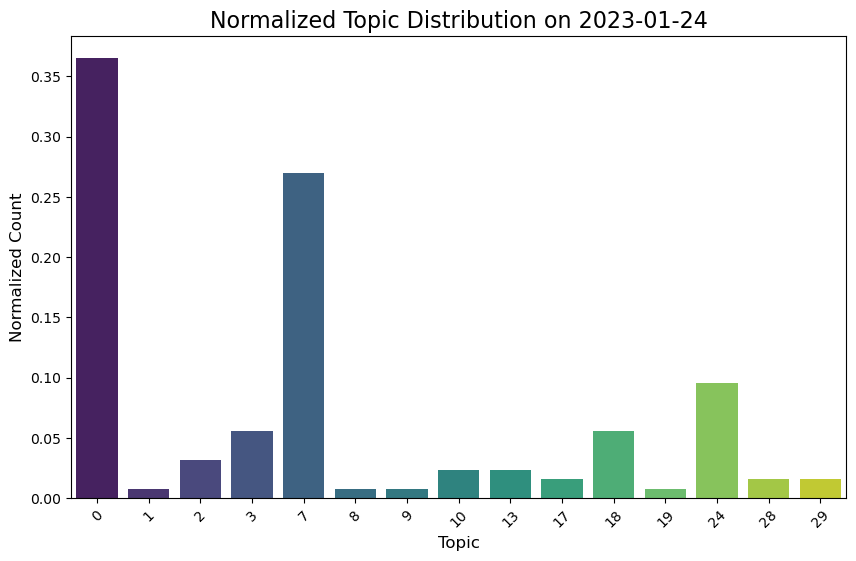

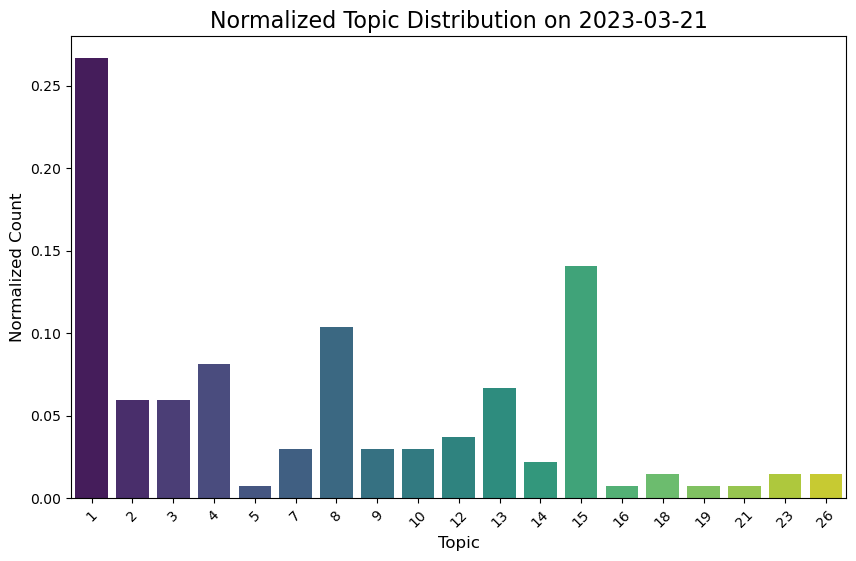

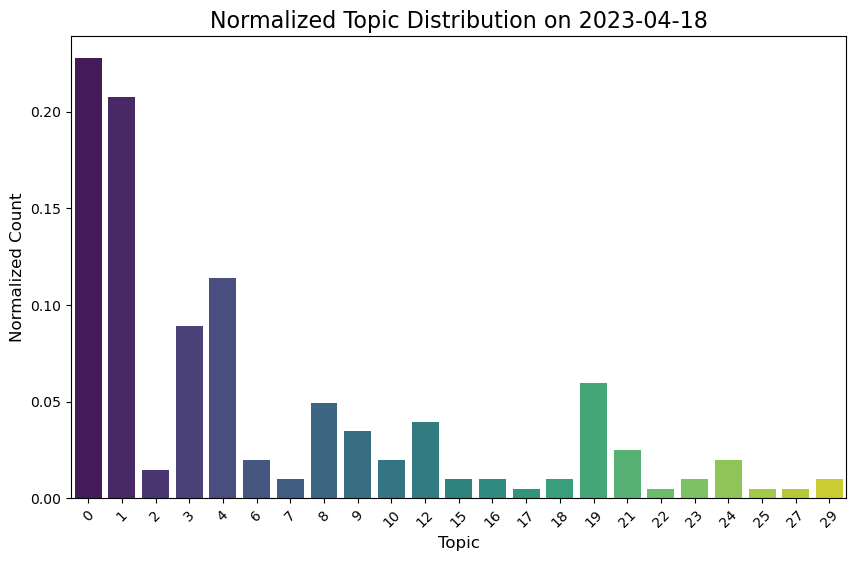

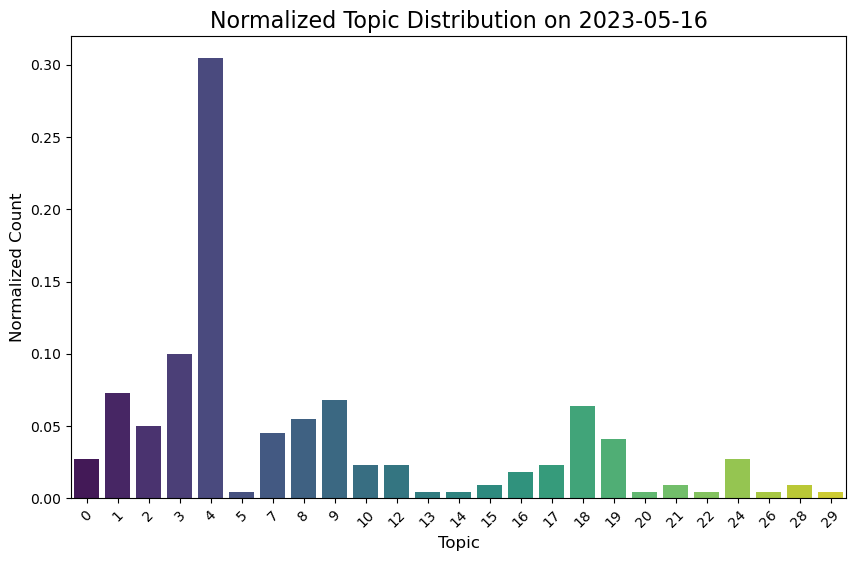

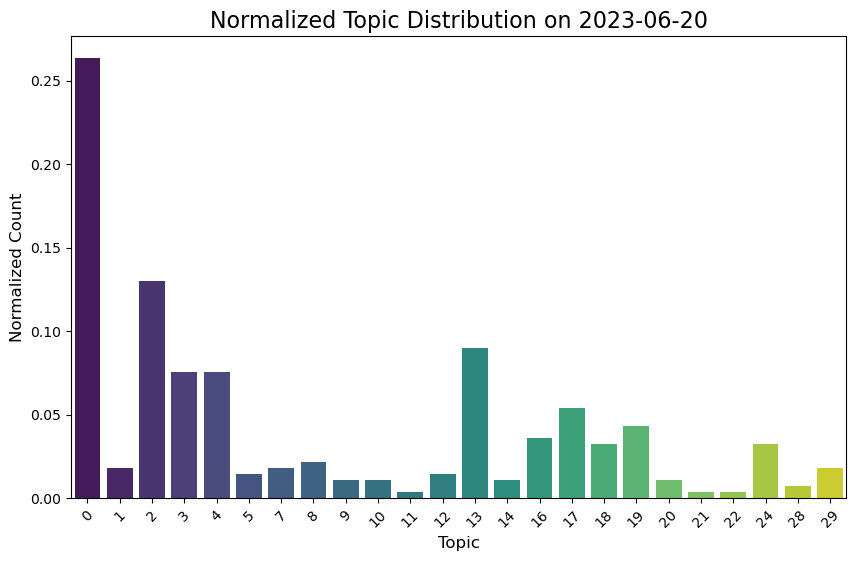

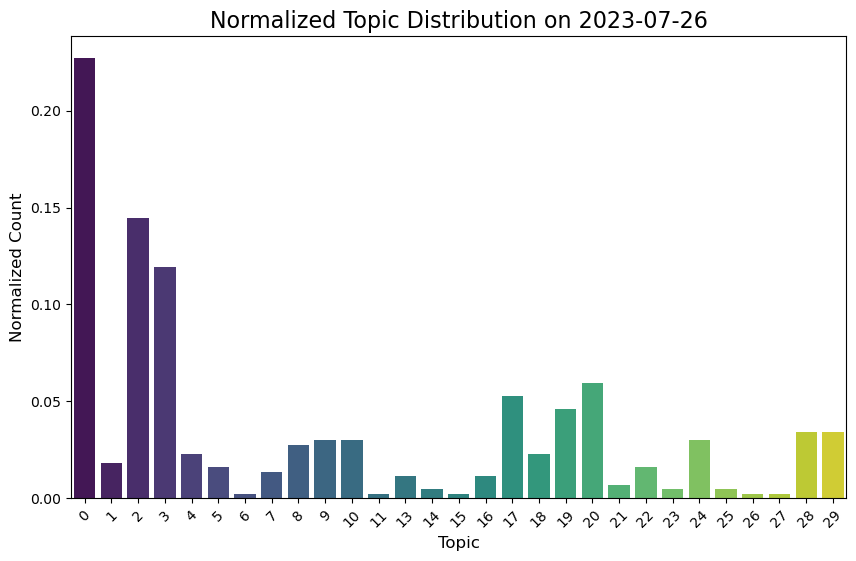

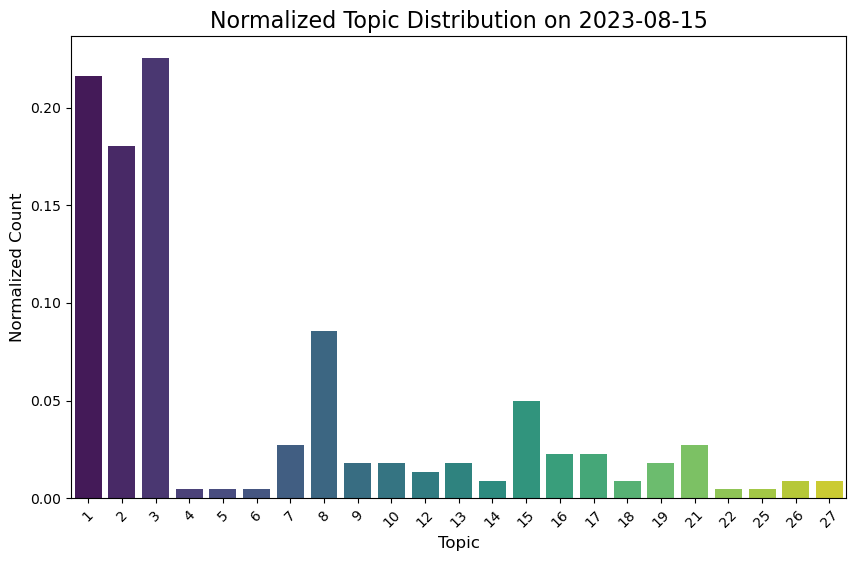

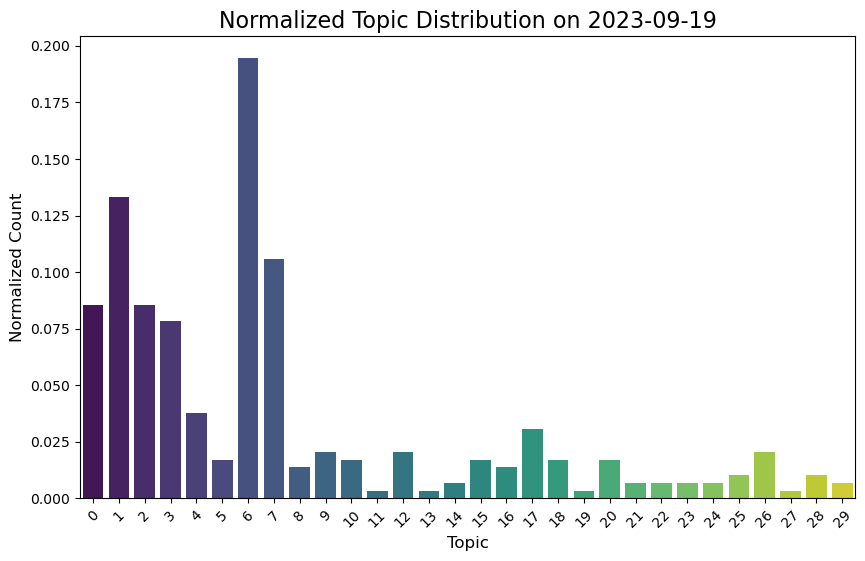

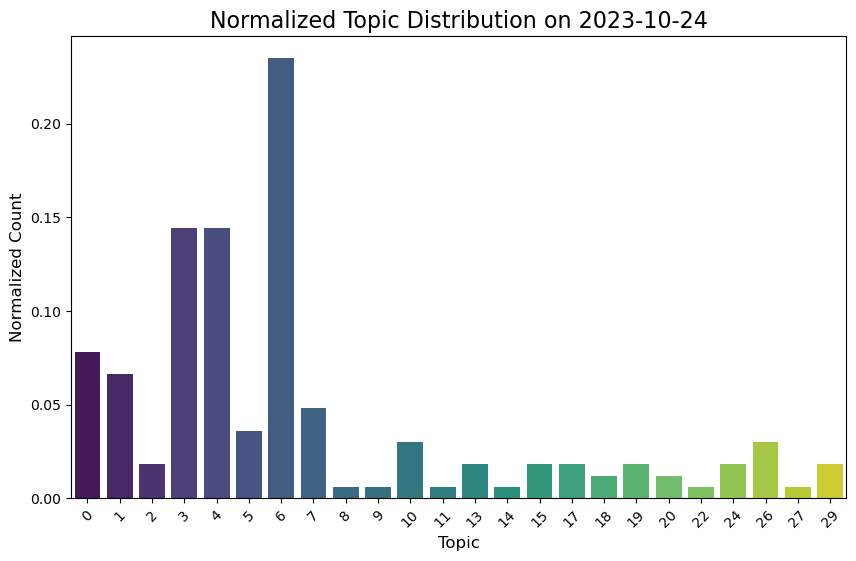

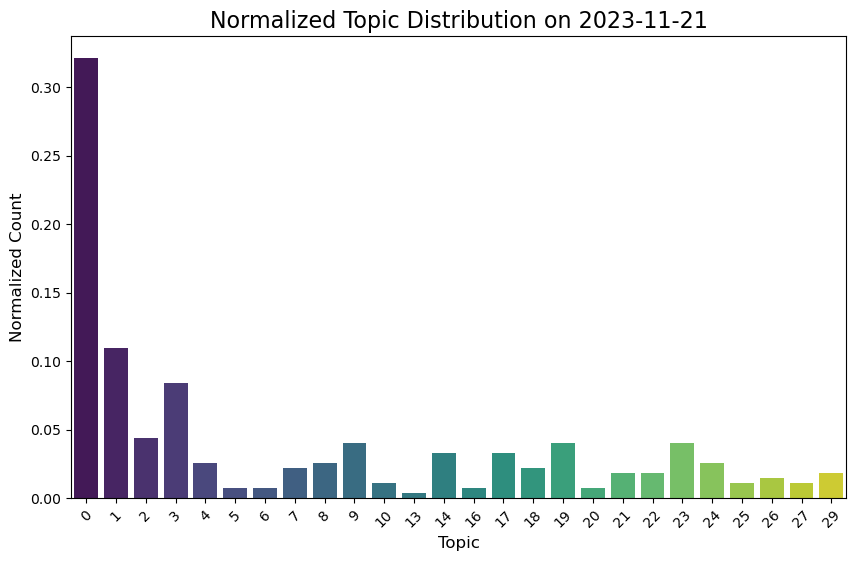

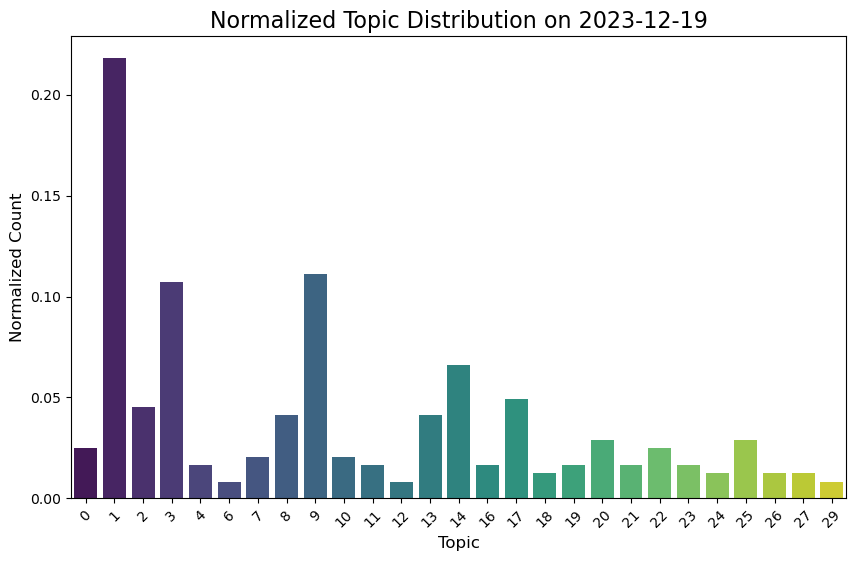

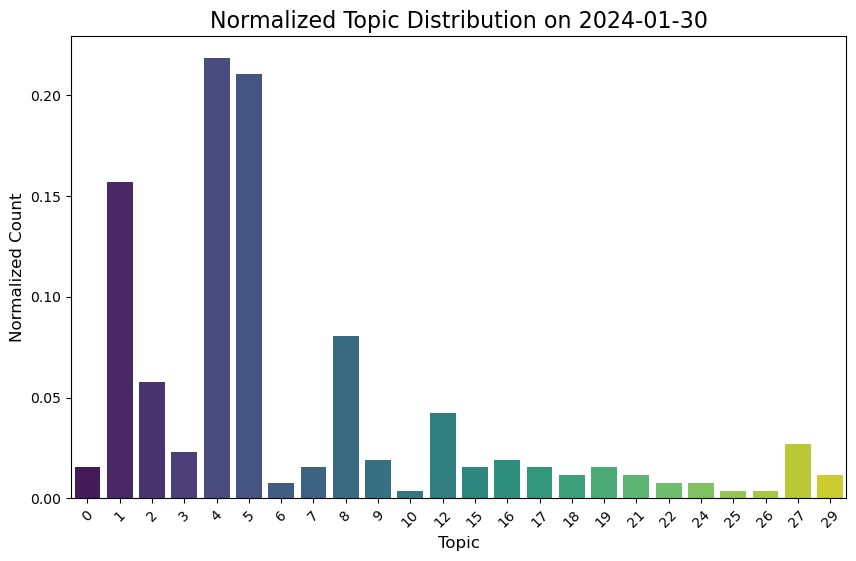

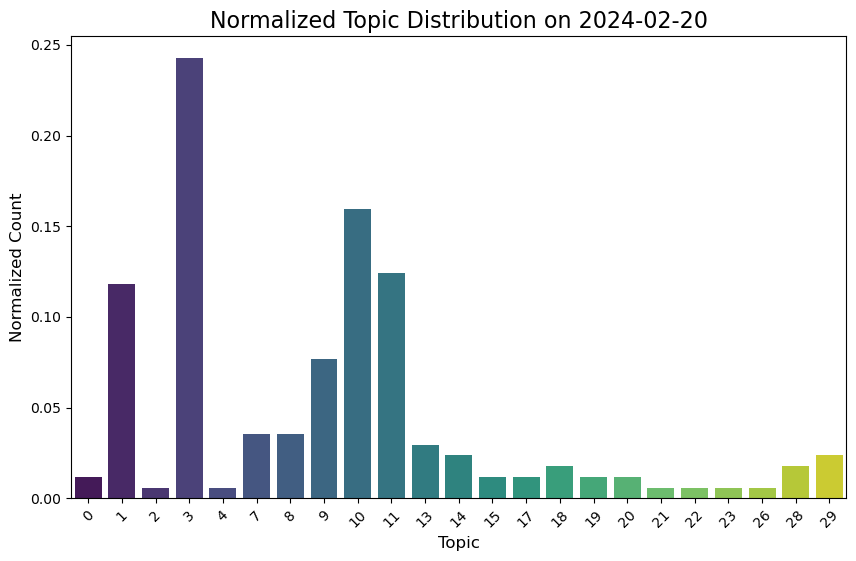

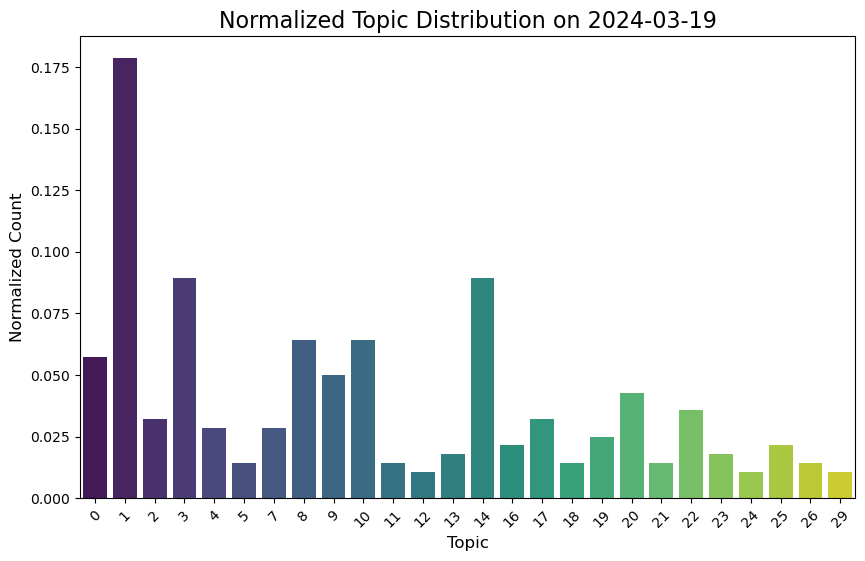

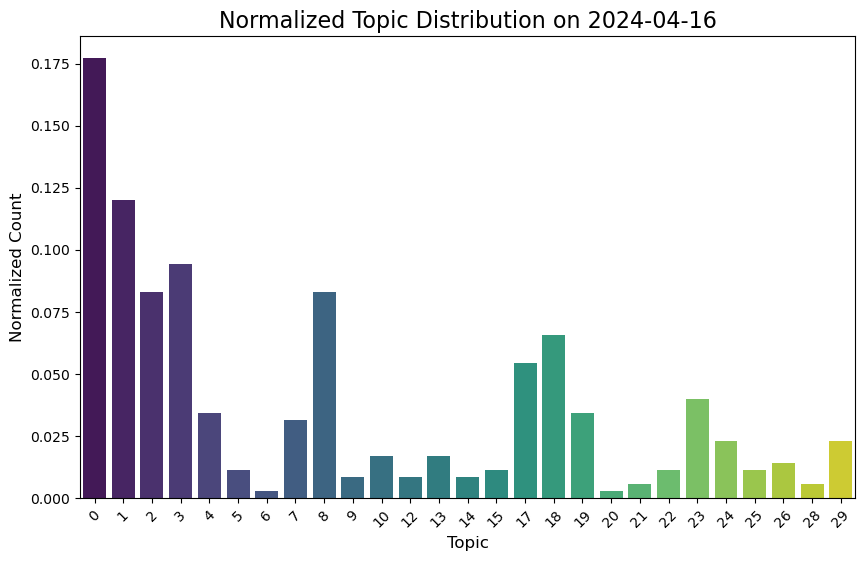

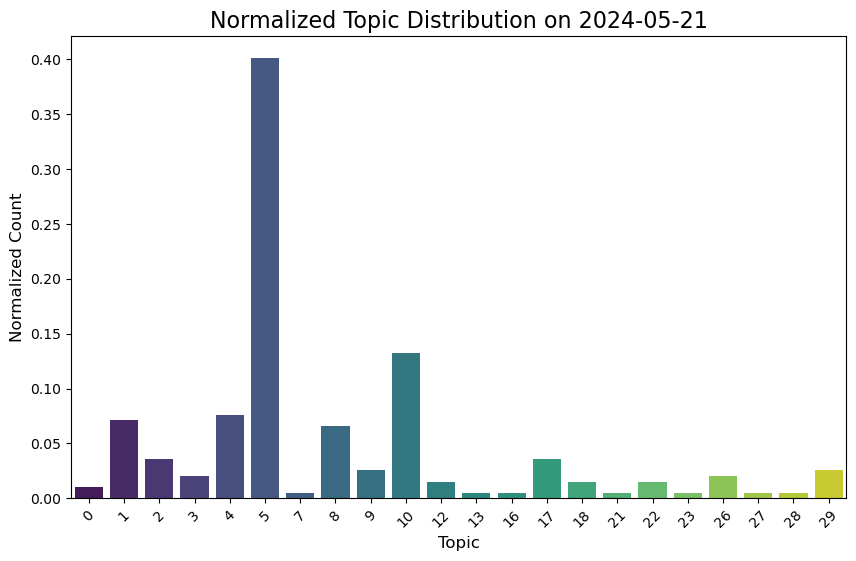

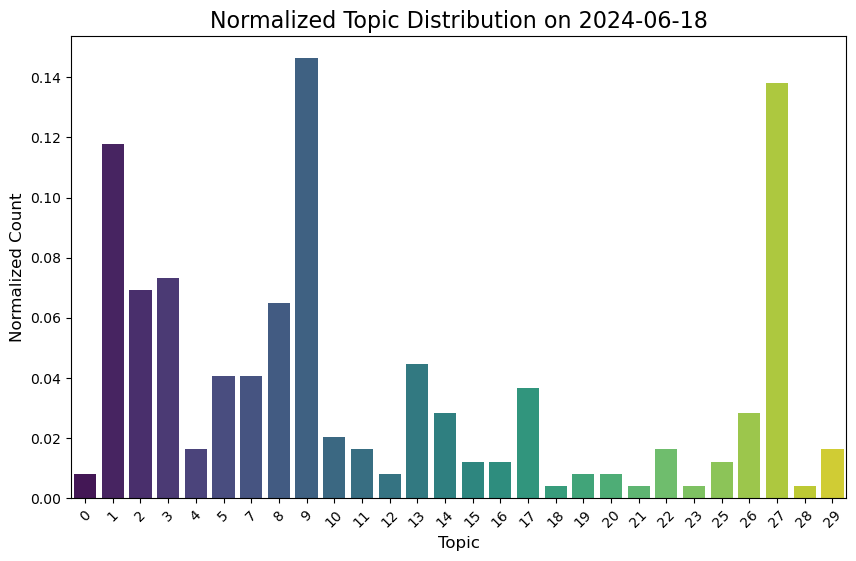

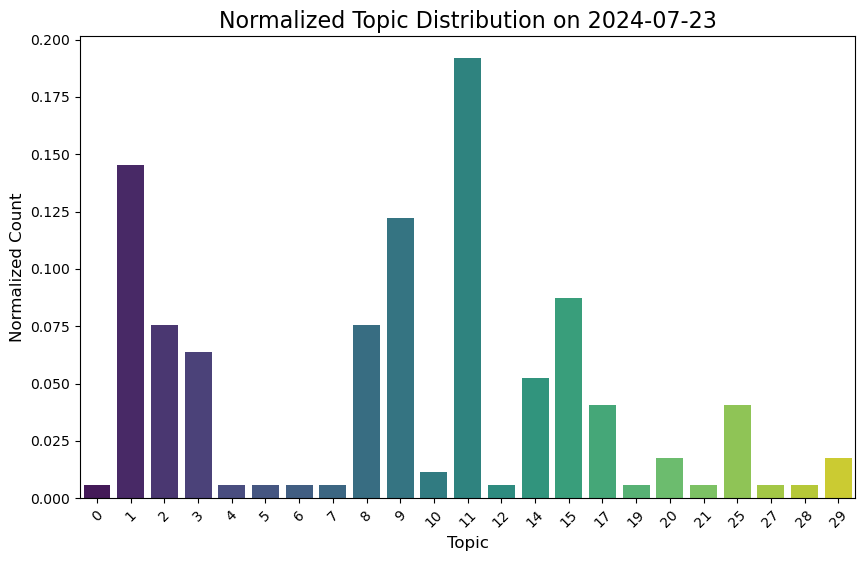

In [275]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your data is already in a DataFrame called df
topic_counts_per_date['date'] = pd.to_datetime(topic_counts_per_date['date'])  # Ensure 'date' is a datetime object

# Get the unique dates from the DataFrame
topic_counts_per_date['normalized_count'] = topic_counts_per_date.groupby('date')['count'].transform(lambda x: x / x.sum())

unique_dates = topic_counts_per_date['date'].unique()

# Loop through each date and create a bar chart
for date in unique_dates:
    # Filter data for the current date
    date_df = topic_counts_per_date[topic_counts_per_date['date'] == date]
    
    # Create the bar plot for normalized counts
    plt.figure(figsize=(10, 6))
    sns.barplot(x='topic', y='normalized_count', data=date_df, palette='viridis')

    # Add titles and labels
    plt.title(f"Normalized Topic Distribution on {date.date()}", fontsize=16)
    plt.xlabel("Topic", fontsize=12)
    plt.ylabel("Normalized Count", fontsize=12)

    # Show the plot
    plt.xticks(rotation=45)
    plt.show()

In [276]:
pd.set_option('display.max_colwidth', None)

# Ensure the 'date' column is in datetime format
topic_counts_per_date['date'] = pd.to_datetime(topic_counts_per_date['date'])

# # Step 1: Group by 'date' and 'topic', then count the number of occurrences of each topic per date
# topic_counts_per_date = long_lines_df_8_with_embeddings.groupby(['date', 'topic']).size().reset_index(name='count')

# Step 2: Sort by 'date' and 'count' (descending order to get the most frequent topics first)
topic_counts_per_date = topic_counts_per_date.sort_values(by=['date', 'normalized_count'], ascending=[True, False])

# Step 3: Group by 'date' and select the top 2 topics for each date
top_2_topics_per_date = topic_counts_per_date.groupby('date').head(3)

# Display the result
#print(top_2_topics_per_date)

# Perform the merge, specifying the column names to merge on
merged_df = pd.merge(top_2_topics_per_date, topic_model.get_topic_info(), left_on='topic', right_on='Topic', how='left')

# Optionally, drop the 'Topic' column from df_with_titles after the merge if you don't need both 'topic' and 'Topic'
merged_df = merged_df.drop(columns=['Topic',"Representation","Representative_Docs","Count"])

# Display the merged DataFrame
merged_df

,date,topic,count,normalized_count,Name
0,2023-01-24,0,46,0.365079,0_Red Hill Environmental Remediation and Water Quality Monitoring Efforts
1,2023-01-24,7,34,0.269841,7_Support for Kaleo Manuel's Reappointment as Deputy Director of the Water Commission
2,2023-01-24,24,12,0.095238,24_Community Feedback on Water Quality Data and Accessibility
3,2023-03-21,1,36,0.266667,1_Water Resource Management and Public Trust Issues in Hawaiʻi
4,2023-03-21,15,19,0.140741,15_Traditional and Customary Rights of Native Hawaiians and Their Legal Implications
5,2023-03-21,8,14,0.103704,8_Commission Discussions on Contested Case Hearing and Permit Review Process
6,2023-04-18,0,46,0.227723,0_Red Hill Environmental Remediation and Water Quality Monitoring Efforts
7,2023-04-18,1,42,0.207921,1_Water Resource Management and Public Trust Issues in Hawaiʻi
8,2023-04-18,4,23,0.113861,4_Stream Flow Management and Diversion Modifications in West Maui
9,2023-05-16,4,67,0.304545,4_Stream Flow Management and Diversion Modifications in West Maui


In [277]:

grouped = merged_df.groupby('date')

# Loop through each group (each date) and print the top 3 topics separately
for date, group in grouped:
    print(f"Top 3 topics for {date}:")
    print(group[['topic', 'normalized_count']])
    print("\n" + "="*40 + "\n")

Top 3 topics for 2023-01-24 00:00:00:
   topic  normalized_count
0      0          0.365079
1      7          0.269841
2     24          0.095238


Top 3 topics for 2023-03-21 00:00:00:
   topic  normalized_count
3      1          0.266667
4     15          0.140741
5      8          0.103704


Top 3 topics for 2023-04-18 00:00:00:
   topic  normalized_count
6      0          0.227723
7      1          0.207921
8      4          0.113861


Top 3 topics for 2023-05-16 00:00:00:
    topic  normalized_count
9       4          0.304545
10      3          0.100000
11      1          0.072727


Top 3 topics for 2023-06-20 00:00:00:
    topic  normalized_count
12      0          0.263538
13      2          0.129964
14     13          0.090253


Top 3 topics for 2023-07-26 00:00:00:
    topic  normalized_count
15      0          0.227064
16      2          0.144495
17      3          0.119266


Top 3 topics for 2023-08-15 00:00:00:
    topic  normalized_count
18      3          0.225225
19    

In [287]:
topic_model.get_topic_freq()
# Perform the merge, specifying the column names to merge on
merged_df = pd.merge(topic_model.get_topic_freq(), topic_model.get_topic_info(), on='Topic', how='left')

# Optionally, drop the 'Topic' column from df_with_titles after the merge if you don't need both 'topic' and 'Topic'
merged_df = merged_df.drop(columns=["Name","Representative_Docs"])

# Display the merged DataFrame
merged_df

,Topic,Count_x,Count_y,Representation
0,-1,2001,2001,[Public Water Management Concerns and Community Engagement in Maui]
1,0,345,345,[Red Hill Environmental Remediation and Water Quality Monitoring Efforts]
2,1,248,248,[Water Resource Management and Public Trust Issues in Hawaiʻi]
3,2,205,205,[Zoom Meeting Discussion on Item B-1]
4,3,189,189,[Water Resource Management and Infrastructure Planning in Hawai‘i]
5,4,183,183,[Stream Flow Management and Diversion Modifications in West Maui]
6,5,143,143,[KIUC Phase One Agreement and Cost Estimates for Modifications]
7,6,98,98,[West Maui Water Rights and Management Debate]
8,7,88,88,[Support for Kaleo Manuel's Reappointment as Deputy Director of the Water Commission]
9,8,80,80,[Commission Discussions on Contested Case Hearing and Permit Review Process]


In [289]:
topic_model.reduce_topics(texts, nr_topics=20)
topic_model.get_topic_freq()
# Perform the merge, specifying the column names to merge on
merged_df = pd.merge(topic_model.get_topic_freq(), topic_model.get_topic_info(), on='Topic', how='left')

# Optionally, drop the 'Topic' column from df_with_titles after the merge if you don't need both 'topic' and 'Topic'
merged_df = merged_df.drop(columns=["Name","Representative_Docs"])

# Display the merged DataFrame
merged_df

,Topic,Count_x,Count_y,Representation
0,-1,2001,2001,[Water Resource Management Concerns in Maui]
1,0,613,613,[Water Management and Remediation Efforts in Hawai‘i]
2,1,321,321,[Water Resource Management and Community Equity in Hawaii]
3,2,205,205,[Commissioners' Meeting Discussion]
4,3,183,183,[Water Flow Management and Monitoring in Maui Streams]
5,4,162,162,[Support for Kaleo Manuel's Reappointment as Deputy Director of the Water Commission]
6,5,146,146,[Commission Delegation and Rulemaking Concerns]
7,6,143,143,[KIUC Phase One Modifications and Funding Dispute]
8,7,98,98,[Reinstate Kaleo Manuel and Uphold Water Rights in Lahaina and West Maui]
9,8,87,87,[Stream Diversion and Channel Alteration Permit Approvals in Hawaii]
